In [1]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import ndtri
from scipy.stats import chi2
from scipy.stats import t
from scipy.stats import f
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import random
from scipy.stats import shapiro
from scipy.stats import bartlett


In [2]:
graph_df = pd.read_csv(r'../data/graph_properties.csv')
graph_df['graph_id'] = graph_df.index + 1
graph_df.head()

,Index,File,Nodes,NumLayers,NumEdges,EdgeDensity,AvgNodesPerLayer,AvgEdgesPerLayer,graph_id
0,0,north/g.10.72.graphml,12,6,13,0.520000,2.000000,2.600000,1
1,1,north/g.13.45.graphml,13,4,12,0.342857,3.250000,4.000000,2
2,2,north/g.10.11.graphml,10,5,14,1.000000,2.000000,3.500000,3
3,3,Rome-Lib/graficon11nodi/grafo233.11,18,8,19,0.475000,2.250000,2.714286,4
4,4,Rome-Lib/graficon12nodi/grafo2240.12,16,7,17,0.485714,2.285714,2.833333,5


In [3]:
df = pd.read_csv(r'../data/direct_transitivity_data.csv')
df.head()

,Index,File,Nodes,Total Nodes,Butterflies,X-vars,C-vars,Total vars,Total constraints,Crossings,...,config,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8,check_9
0,0,north/g.10.72.graphml,10,12,0,8,7,15,20,0,...,d_235689,0,1,1,0,1,1,0,1,1
1,1,north/g.13.45.graphml,13,13,0,6,2,8,8,0,...,d_235689,0,1,1,0,1,1,0,1,1
2,2,north/g.10.11.graphml,10,10,0,15,0,15,40,0,...,d_235689,0,1,1,0,1,1,0,1,1
3,3,Rome-Lib/graficon11nodi/grafo233.11,11,18,0,15,12,27,36,0,...,d_235689,0,1,1,0,1,1,0,1,1
4,4,Rome-Lib/graficon12nodi/grafo2240.12,12,16,0,12,11,23,30,0,...,d_235689,0,1,1,0,1,1,0,1,1


In [4]:
joined_df = df.merge(graph_df, on = 'File')
joined_df = joined_df[['graph_id','Total Nodes', 'Crossings','Opttime','Status','config', 'check_1', 'check_2',
       'check_3', 'check_4', 'check_5', 'check_6', 'check_7', 'check_8',
       'check_9' ]]

joined_df.head()

,graph_id,Total Nodes,Crossings,Opttime,Status,config,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8,check_9
0,1,12,0,0.000556,2,d_235689,0,1,1,0,1,1,0,1,1
1,1,12,0,0.000984,2,d_158,1,0,0,0,1,0,0,1,0
2,1,12,0,0.000857,2,d_1567,1,0,0,0,1,1,1,0,0
3,1,12,0,0.000621,2,d_234568,0,1,1,1,1,1,0,1,0
4,1,12,0,0.000661,2,d_58,0,0,0,0,1,0,0,1,0


In [10]:
joined_df['config'].replace('d_','d_0', inplace=True)
joined_df[joined_df['config'] == 'd_0']
joined_df['combination']=joined_df['config'].str.split('_').str[1]
joined_df['combination'] = joined_df['combination'].astype('category')
joined_df.head()

,graph_id,Total Nodes,Crossings,Opttime,Status,config,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8,check_9,combination
0,1,12,0,0.000556,2,d_235689,0,1,1,0,1,1,0,1,1,235689
1,1,12,0,0.000984,2,d_158,1,0,0,0,1,0,0,1,0,158
2,1,12,0,0.000857,2,d_1567,1,0,0,0,1,1,1,0,0,1567
3,1,12,0,0.000621,2,d_234568,0,1,1,1,1,1,0,1,0,234568
4,1,12,0,0.000661,2,d_58,0,0,0,0,1,0,0,1,0,58


In [11]:
cols_of_interest = ['graph_id','Total Nodes','Crossings', 'combination','Status','Opttime']
main_df = joined_df[cols_of_interest]

np.random.seed(42)
random_graph = np.random.randint(1, 1150, 100)
random_graph

main_df_sample = main_df[main_df['graph_id'].isin(random_graph)]


In [13]:
main_df_sample = main_df_sample[['combination','graph_id','Opttime']]
main_df_sample['graph_id'] = main_df_sample['graph_id'].astype('category')
main_df_sample.sort_values(by=['combination', 'graph_id'], inplace=True)
main_df_sample.shape

(50176, 3)

In [14]:
# Performing two-way ANOVA 
model_2 = ols('Opttime ~ C(combination) + C(graph_id)', data=main_df_sample).fit() 


In [15]:

aov_table_2 = sm.stats.anova_lm(model_2, typ=2)
print(f"aov_table:\n {aov_table_2}")

aov_table:
                       sum_sq       df            F  PR(>F)
C(combination)  1.062337e+06    511.0    29.110671     0.0
C(graph_id)     3.062547e+07     97.0  4421.014267     0.0
Residual        3.539824e+06  49567.0          NaN     NaN


# Testing Assumptions of Anova Model


### Normality

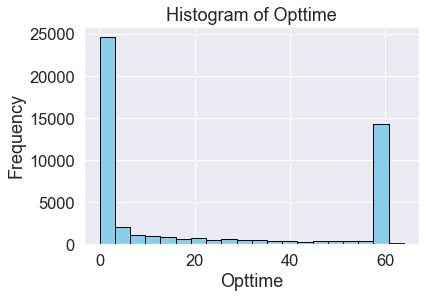

In [12]:
plt.hist(main_df_sample['Opttime'], bins='auto', color='skyblue', edgecolor='black')
plt.title('Histogram of Opttime')
plt.xlabel('Opttime')
plt.ylabel('Frequency')
plt.show()

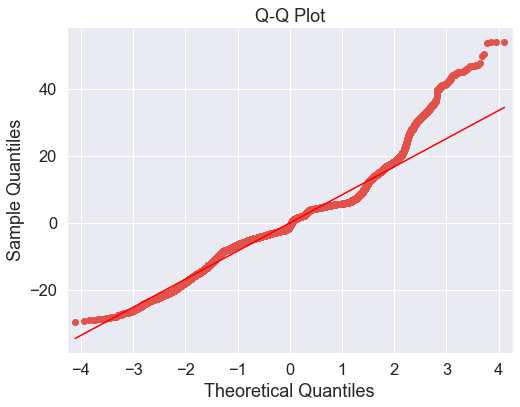

In [16]:
residuals = model_2.resid

# Create Q-Q plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)

# Add a straight diagonal line to the plot
ax.set_title('Q-Q Plot')
plt.show()

In [17]:
opttime_data = main_df_sample['Opttime']

# Conduct the Shapiro-Wilk test
statistic, p_value = shapiro(opttime_data)

# Print the results
print("Shapiro-Wilk normality test:")
print(f"Statistic: {statistic}, p-value: {p_value}")

Shapiro-Wilk normality test:
Statistic: 0.7109732627868652, p-value: 0.0


# Equal Variance

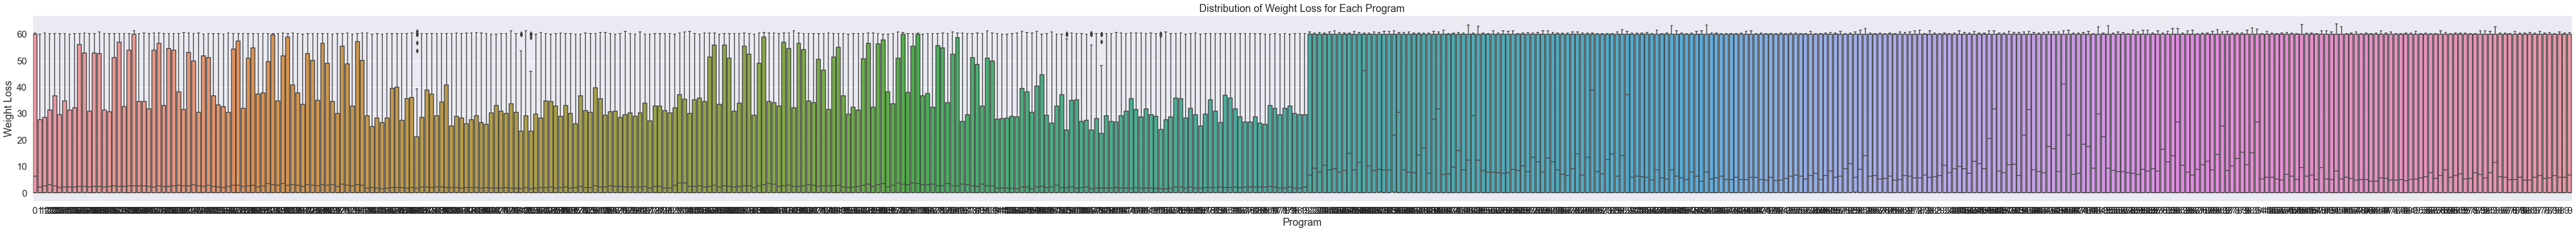

In [18]:
plt.figure(figsize=(80, 6))
sns.boxplot(x='combination', y='Opttime', data=main_df_sample)
plt.xlabel('Program')
plt.ylabel('Weight Loss')
plt.title('Distribution of Weight Loss for Each Program')
plt.show()

In [19]:
statistic, p_value = bartlett(*[main_df_sample['Opttime'][main_df_sample['combination'] == combination] for combination in main_df_sample['combination'].unique()])
print(f"Bartlett's test statistic: {statistic}, p-value: {p_value}")

Bartlett's test statistic: 784.4309130364289, p-value: 6.95550713427739e-14
